In [1]:
import glob
import torch
import os
import math
import numpy as np

from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

from utils.image_helpers import plot_image_grid, rgb2gray
from utils.evaluation_helpers import calculate_model_performances, calculate_noisy_performance, split_performances, split_result_list
from utils.pickle_utils import load_results
from fitting.Result import calculate_combination_results

In [2]:
def get_most_recent_gridsearch():
    file_paths = glob.glob("data/results/*gridsearch.pkl")
    file_paths.sort()
    return file_paths[-1]

# Load Results

In [3]:
#most recent
file_path = get_most_recent_gridsearch()

# 10 ImageNet v2 with deep
#file_path = 'data/results/2020-11-24-22:11-gridsearch.pkl'

results = load_results(file_path)
print(file_path)
print('Number of Runs loaded:', len(results))

for result in results:
    result.best_loss_wrt_noisy = result.best_loss_wrt_noisy.cpu()

data/results/2020-11-30-09:24-gridsearch.pkl
Number of Runs loaded: 1721


In [4]:
gridsearch_running = True
runs_per_image = 600
if gridsearch_running:
    number_of_images = math.floor(len(results)/runs_per_image)
    results = results[:number_of_images*runs_per_image]
    print(f'Number of Images processed: {number_of_images}')

Number of Images processed: 2


# Plot model performance

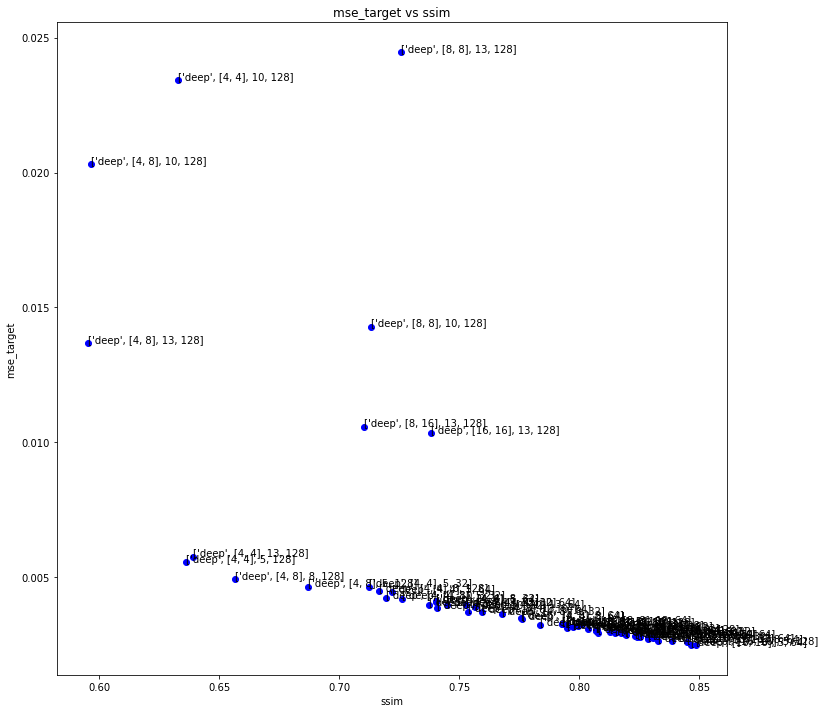

In [5]:
average_performances = calculate_model_performances(results)
noisy_performance = calculate_noisy_performance(results)
filtered_performances = average_performances
#filtered_performances = filter(lambda x: x['mse_target'] < 0.01, average_performances)
#filtered_performances = filter(lambda x: x['ssim'] > 0.85, average_performances)

plt.figure(figsize=(12,12))

x='ssim'
y='mse_target'

for performance in filtered_performances:
    plt.scatter(performance[x], performance[y], c='b')
    plt.annotate(str(performance['description']), (performance[x], performance[y]))
#plt.scatter(noisy_performance[x], noisy_performance[y], c='y')
#plt.annotate('Noisy Image', (noisy_performance[x], noisy_performance[y]))
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} vs {x}')
plt.show()

# Visualize different archichtecture parameters

In [6]:
type_performances = split_performances(average_performances, split_type='model_type')
input_performances = split_performances(average_performances, split_type='input_shape')
layer_performances = split_performances(average_performances, split_type='number_of_layers')
channel_performances = split_performances(average_performances, split_type='number_of_channels')

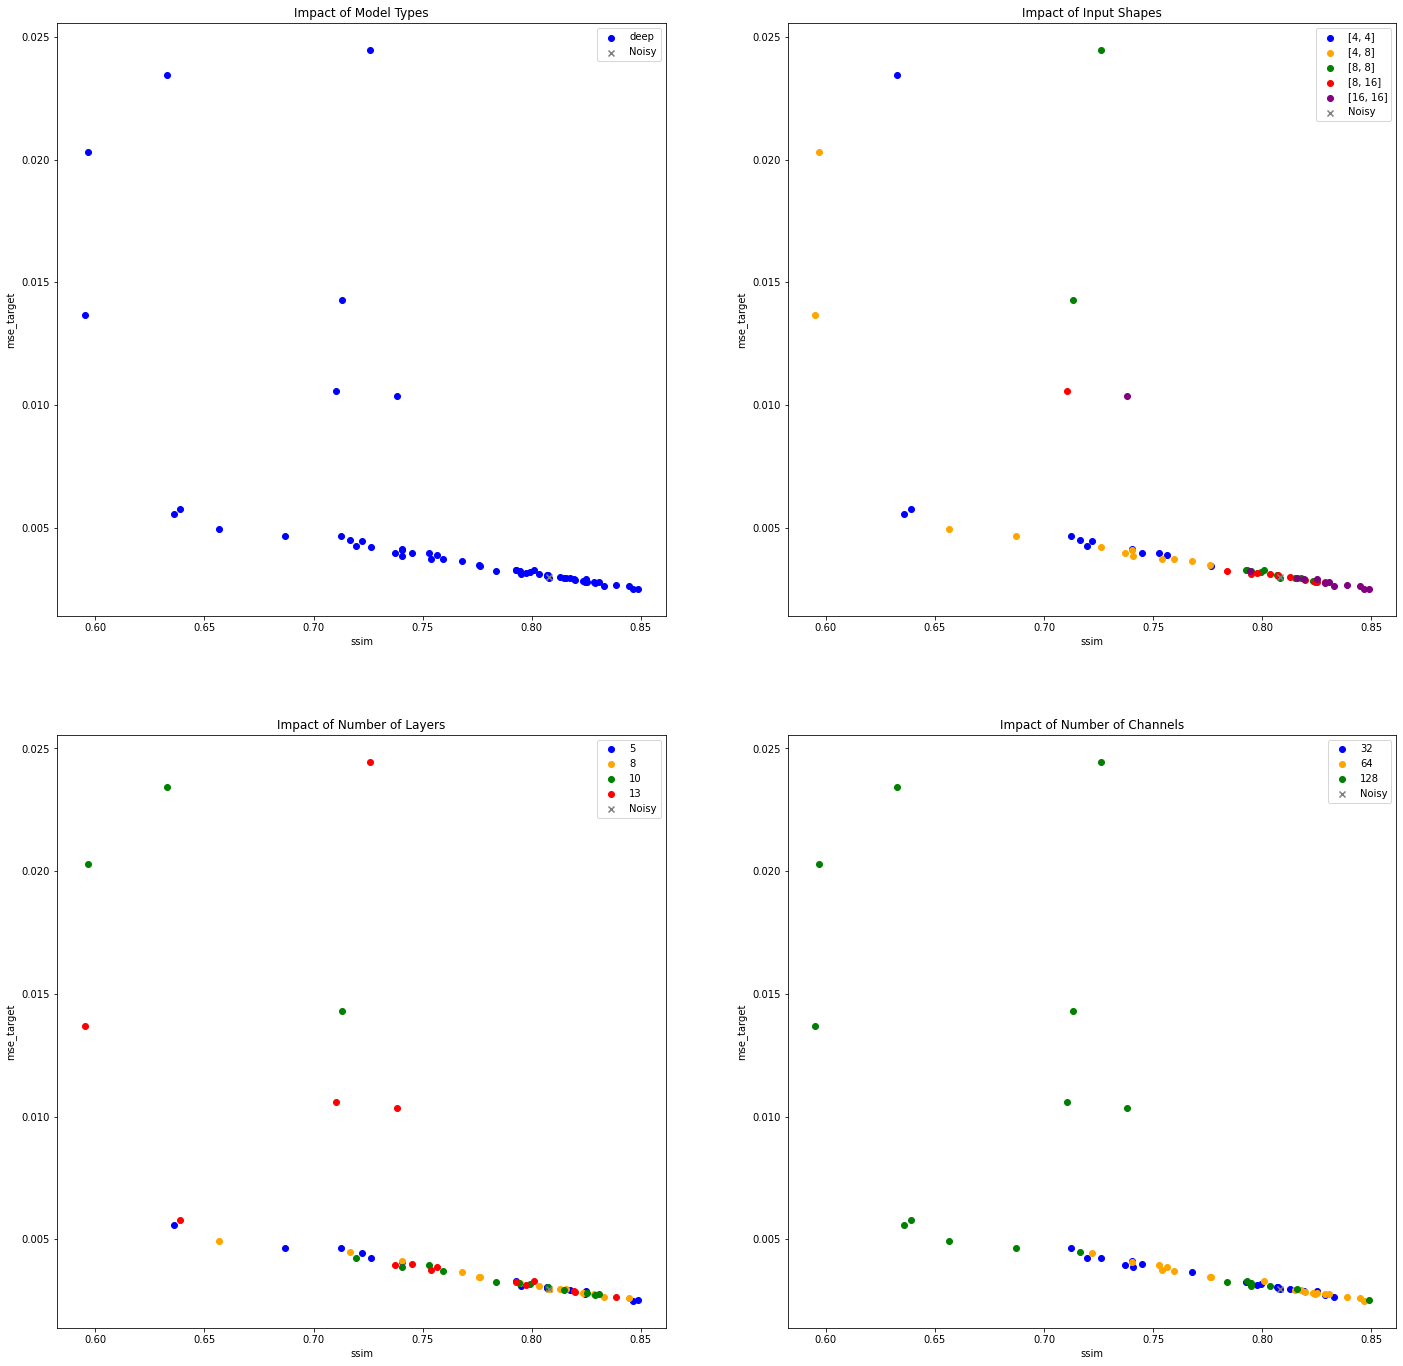

In [7]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan' ]
figure, axes = plt.subplots(2, 2, figsize=(24,24))

x = 'ssim'
y = 'mse_target'

for index, performances_key in enumerate(type_performances):
    x_list = [performance[x] for performance in type_performances[performances_key]]
    y_list = [performance[y] for performance in type_performances[performances_key]]
    axes[0][0].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[0][0].set_title('Impact of Model Types')
for index, performances_key in enumerate(input_performances):
    x_list = [performance[x] for performance in input_performances[performances_key]]
    y_list = [performance[y] for performance in input_performances[performances_key]]
    axes[0][1].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[0][1].set_title('Impact of Input Shapes')
for index, performances_key in enumerate(layer_performances):
    x_list = [performance[x] for performance in layer_performances[performances_key]]
    y_list = [performance[y] for performance in layer_performances[performances_key]]
    axes[1][0].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[1][0].set_title('Impact of Number of Layers')
for index, performances_key in enumerate(channel_performances):
    x_list = [performance[x] for performance in channel_performances[performances_key]]
    y_list = [performance[y] for performance in channel_performances[performances_key]]
    axes[1][1].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[1][1].set_title('Impact of Number of Channels')

for axis in axes.flatten():
    axis.scatter(noisy_performance[x], noisy_performance[y], color='gray', marker='x', label='Noisy')
    axis.legend()
    axis.set_ylabel(y)
    axis.set_xlabel(x)

# Combination of different runs

In [8]:
def choose_noisy(results):
    return results[0].noisy_image

def average_images(results):
    images_to_combine = [x.model_image for x in results]
    return np.mean(images_to_combine, axis=0)

def average_images_and_noisy(results):
    images_to_combine = [x.model_image for x in results]
    images_to_combine.append(results[0].noisy_image)
    return np.mean(images_to_combine, axis=0)

def median_images(results):
    images_to_combine = [x.model_image for x in results]
    return np.median(images_to_combine, axis=0)

def median_images_and_noisy(results):
    images_to_combine = [x.model_image for x in results]
    images_to_combine.append(results[0].noisy_image)
    return np.median(images_to_combine, axis=0)

def average_images_and_more_noisy(results):
    images_to_combine = [x.model_image for x in results]
    images_to_combine.append(results[0].noisy_image)
    images_to_combine.append(results[0].noisy_image)
    return np.mean(images_to_combine, axis=0)

def average_images_and_even_more_noisy(results):
    images_to_combine = [x.model_image for x in results]
    for _ in range(5):
        images_to_combine.append(results[0].noisy_image)
    return np.mean(images_to_combine, axis=0)

def weighted_average(results):
    weights = np.array([x.number_of_iterations for x in results]) #1/x.best_loss_wrt_noisy
    weights = weights/np.sum(weights)
    images_to_combine = [x.model_image for x in results]
    return np.average(images_to_combine, axis=0, weights=weights)

functions = {'Noisy Baseline': choose_noisy, 
             'Average Images': average_images,
             #'Average with Noisy': average_images_and_noisy
             #'Median Images': median_images, 
             #'Median with Noisy': median_images_and_noisy,
             #'Average with more Noisy': average_images_and_more_noisy,
             #'Average with even more Noisy': average_images_and_even_more_noisy,
             #'Weighted Average': weighted_average
            }

for function in functions:
    print(function)

Noisy Baseline
Average Images


In [9]:
all_performances = {}
for function in functions:
    print('Evaluating', function, '...', end='\r')
    new_results = calculate_combination_results(results, image_from_results=functions[function])
    performances = calculate_model_performances(new_results.copy())
    performances.sort(key=lambda x: str(x['description']))
    all_performances[function] = performances
    print('Finished evaluating:', function)

Finished evaluating: Noisy Baseline
Finished evaluating: Average Images


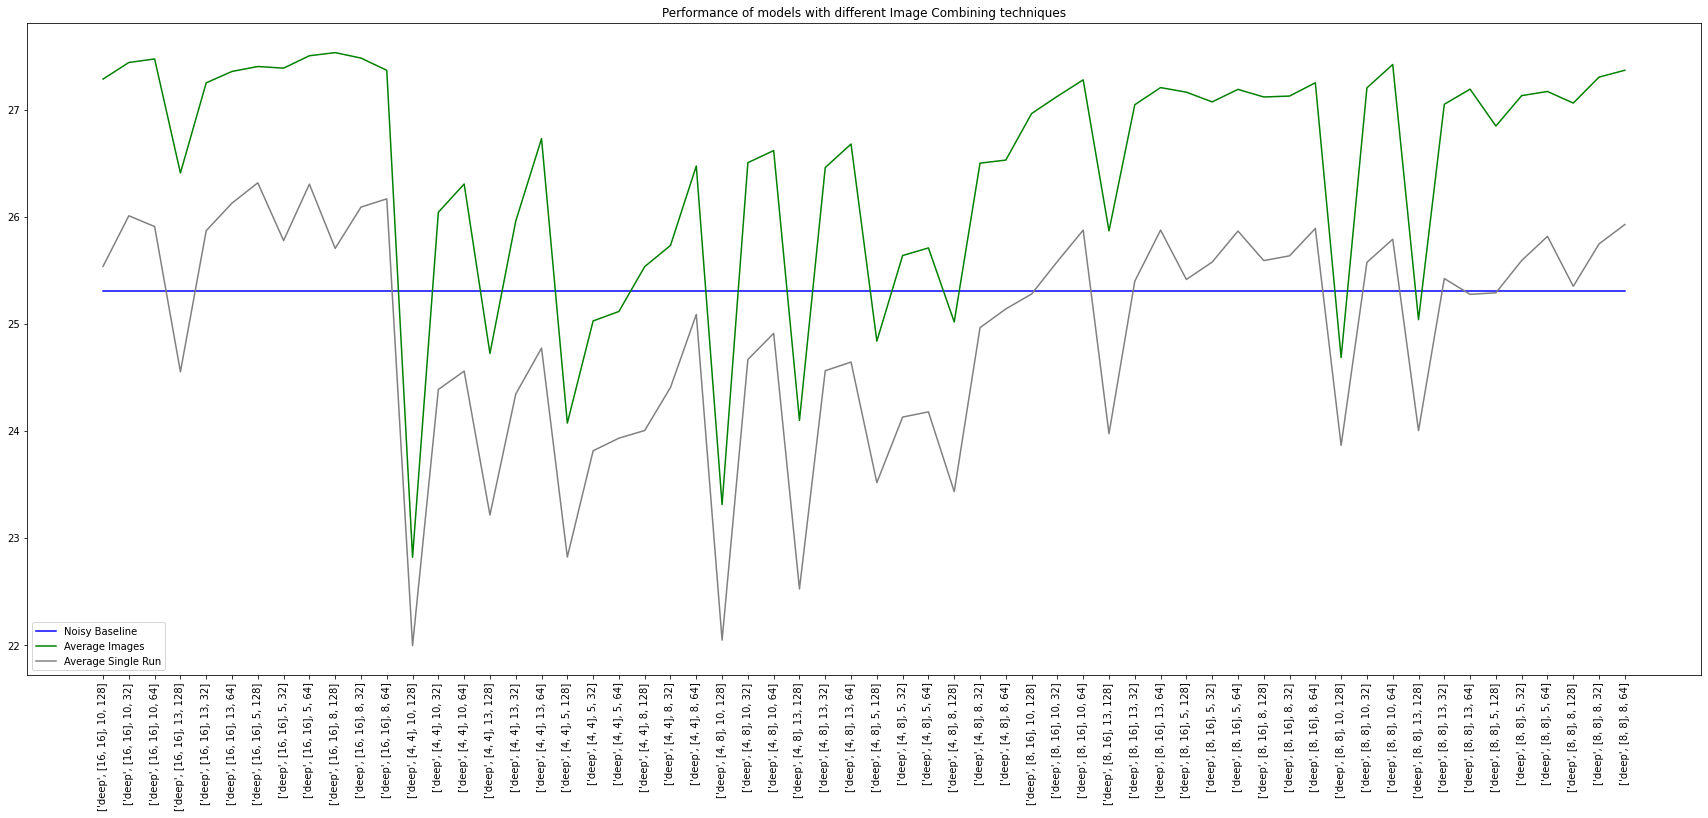

In [10]:
parameter='psnr'
plt.figure(figsize=(30,12))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
function_labels = [str(x['description']) for x in all_performances[function]]
average_labels = [str(x['description']) for x in average_performances]
average_performances = [x for _, x in sorted(zip(average_labels, average_performances), key=lambda pair: pair[0])]
average_labels.sort()

for index, function in enumerate(all_performances):
    plt.plot(function_labels, [x[parameter] for x in all_performances[function]], c=colors[index], label=function)
plt.plot(average_labels, [x[parameter] for x in average_performances], c='gray', label='Average Single Run')
plt.xticks(rotation=90)
plt.title('Performance of models with different Image Combining techniques')
plt.legend()
plt.show()

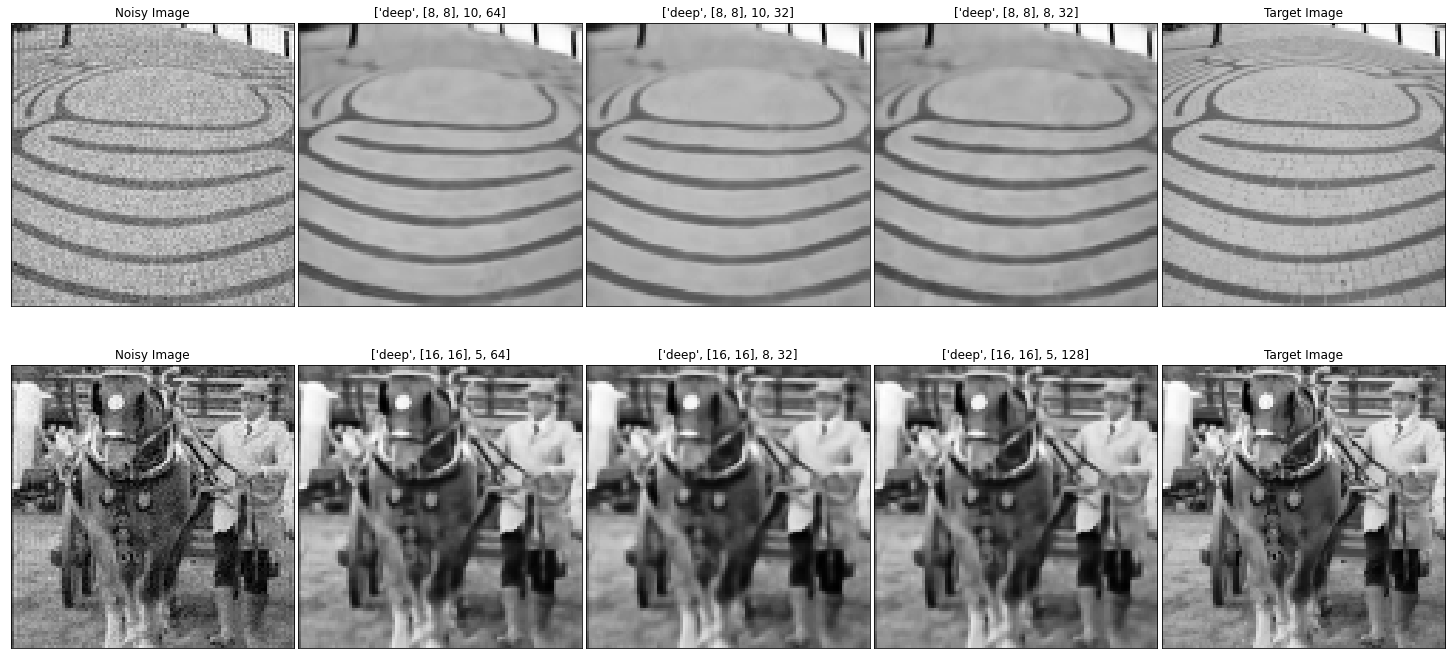

In [11]:
titles = []
images = []
images_results = split_result_list(new_results, model_split=False, image_split=True)
for image_results in images_results:
    image_results.sort(key=lambda x: x.psnr, reverse=True)
    images.append(image_results[0].noisy_image)
    titles.append('Noisy Image')
    images.extend(list(map(lambda x: x.model_image, image_results))[:3])
    titles.extend(list(map(lambda x: str(x.model_parameters), image_results))[:3])
    images.append(image_results[0].target_image)
    titles.append('Target Image')
plot_image_grid(images, titles, ncols=5)
plt.show()

In [12]:
new_average_performances = calculate_model_performances(new_results)

In [13]:
type_performances = split_performances(new_average_performances, split_type='model_type')
input_performances = split_performances(new_average_performances, split_type='input_shape')
layer_performances = split_performances(new_average_performances, split_type='number_of_layers')
channel_performances = split_performances(new_average_performances, split_type='number_of_channels')

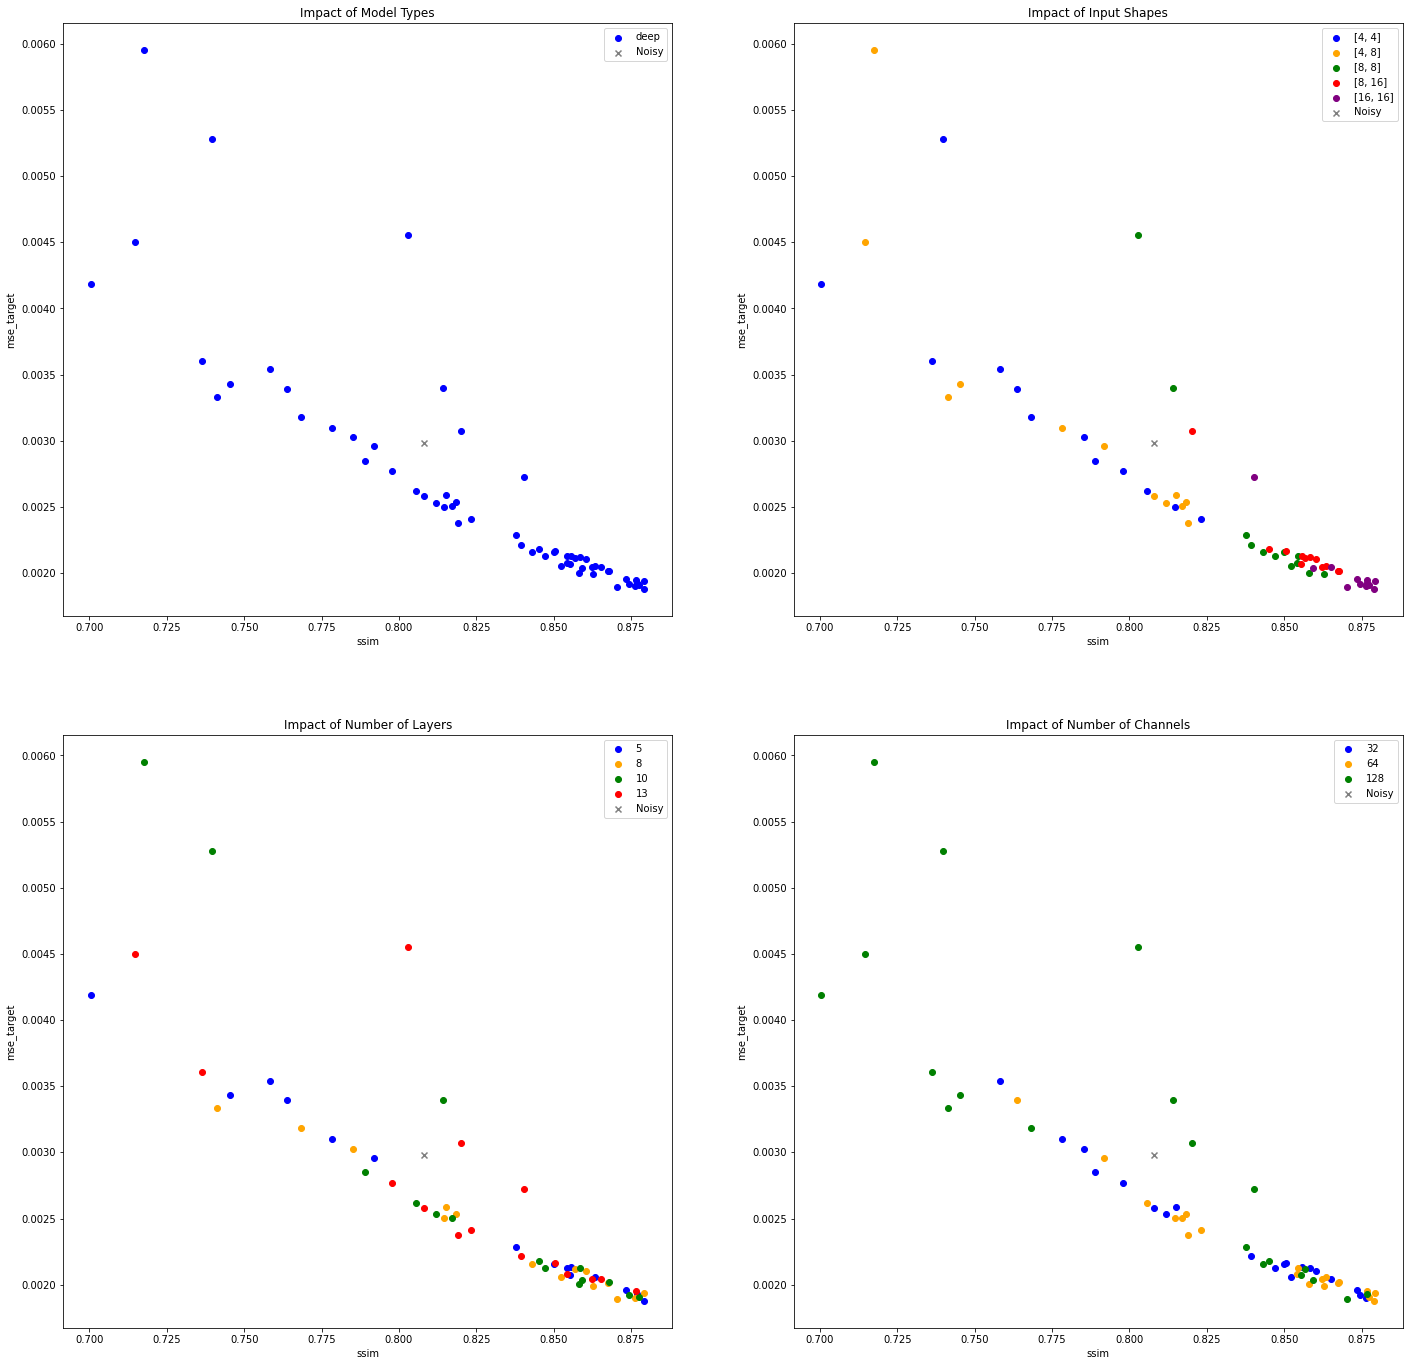

In [14]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan' ]
figure, axes = plt.subplots(2, 2, figsize=(24,24))

x = 'ssim'
y = 'mse_target'

for index, performances_key in enumerate(type_performances):
    x_list = [performance[x] for performance in type_performances[performances_key]]
    y_list = [performance[y] for performance in type_performances[performances_key]]
    axes[0][0].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[0][0].set_title('Impact of Model Types')
for index, performances_key in enumerate(input_performances):
    x_list = [performance[x] for performance in input_performances[performances_key]]
    y_list = [performance[y] for performance in input_performances[performances_key]]
    axes[0][1].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[0][1].set_title('Impact of Input Shapes')
for index, performances_key in enumerate(layer_performances):
    x_list = [performance[x] for performance in layer_performances[performances_key]]
    y_list = [performance[y] for performance in layer_performances[performances_key]]
    axes[1][0].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[1][0].set_title('Impact of Number of Layers')
for index, performances_key in enumerate(channel_performances):
    x_list = [performance[x] for performance in channel_performances[performances_key]]
    y_list = [performance[y] for performance in channel_performances[performances_key]]
    axes[1][1].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[1][1].set_title('Impact of Number of Channels')

for axis in axes.flatten():
    axis.scatter(noisy_performance[x], noisy_performance[y], color='gray', marker='x', label='Noisy')
    axis.legend()
    axis.set_ylabel(y)
    axis.set_xlabel(x)